In [99]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from typing import Tuple
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as albu

We will be only catering to AOI : Rio for now.

ref : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#writing-a-custom-dataset-for-pennfudan, https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [28]:
SATELLITE_IMAGES_PATH = 'data/AOI_1_rio/imgs'
MASKS_PATH = 'data/AOI_1_rio/masks'
IMG_SIZE = (438, 406) # width, height

In [91]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [158]:
# A `Dataset` should override `__len__` and `__getitem__`
class BuildingFootprintDataset(Dataset):
    def __init__(self, satellite_imgs_path:str, masks_path:str, augmentation=None, preprocessing=None) -> None:
        super().__init__()
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        assert os.path.isdir(masks_path)
        assert os.path.isdir(satellite_imgs_path)
        self.satellite_imgs_path = satellite_imgs_path
        self.masks_path = masks_path 
        self.images = sorted(os.listdir(satellite_imgs_path), key=lambda x: int(x.split('.')[0]))
        self.image_masks = sorted(os.listdir(masks_path), key=lambda x: int(x.split('.')[0]))
    def __len__(self):
        return len(self.image_masks)
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.satellite_imgs_path, self.images[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_path, self.image_masks[index]),cv2.IMREAD_GRAYSCALE)
        # split mask into many masks, one per instance
        # each instance has a different color, as defined in the mask creation process from the raster files
        obj_ids = np.sort(np.unique(mask))[1:]
        masks = [(mask == v) for v in obj_ids]
        masks = np.stack(masks, axis=-1).astype('float')
        # mask_np = np.array(mask)
        # print(len(obj_ids))
        # masks = mask_np==obj_ids[:,None,None] 
        # masks = np.stack([m for m in masks],axis=-1)
        
        # apply augmentations
        if self.augmentation:
            # print(masks)
            sample = self.augmentation(image=image, masks_arr=masks, mask=mask)
            image, masks, mask = sample['image'], sample['masks_arr'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, masks_arr=masks,mask=mask)
            image, masks, mask = sample['image'], sample['masks_arr'], sample['mask']
            
        return image, mask, masks
        
    

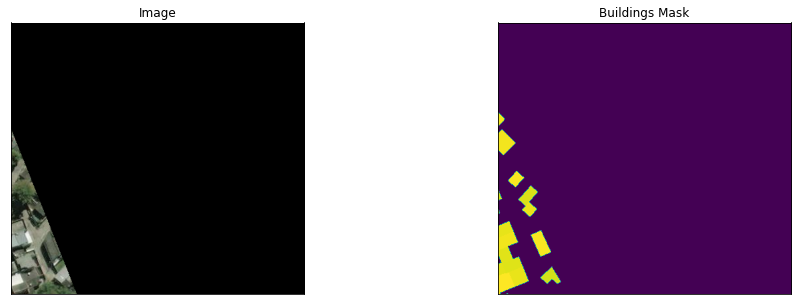

In [159]:
dataset = BuildingFootprintDataset(SATELLITE_IMAGES_PATH,MASKS_PATH)
img, mask, masks = dataset[6939]
visualize(
    image=img,
    buildings_mask=mask
)

Transformations

In [126]:
masks

False

In [164]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(IMG_SIZE[1],IMG_SIZE[0]),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        albu.Resize(IMG_SIZE[1], IMG_SIZE[0])
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

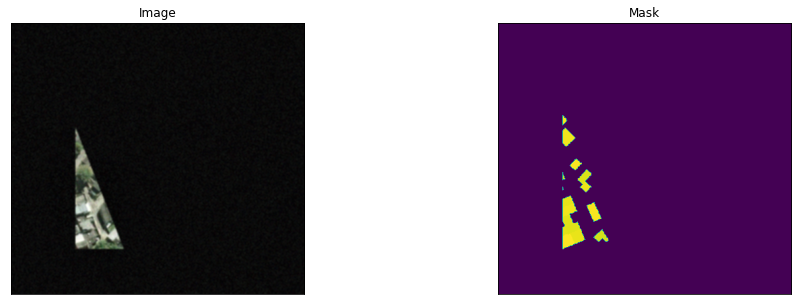

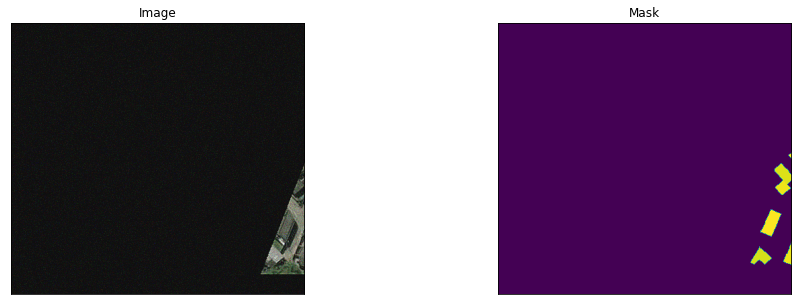

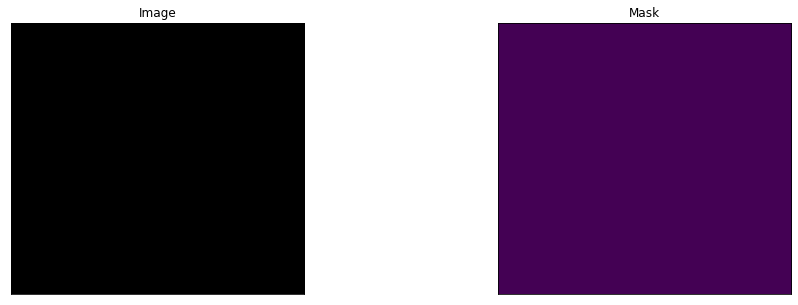

In [166]:
#### Visualize resulted augmented images and masks

augmented_dataset = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    # image, mask, masks = augmented_dataset[1]
    image, mask, masks = augmented_dataset[6939]
    visualize(image=image, mask=mask)

In [17]:
model = smp.Unet(
    encoder_name="resnet34",     
    encoder_weights="imagenet",  
    in_channels=3,               
    classes=1,                   
)

In [20]:
preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

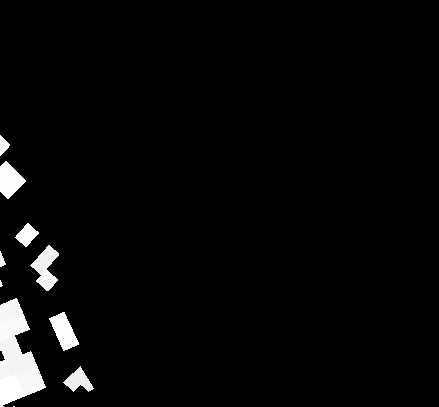

In [112]:
img = Image.open(f'{MASKS_PATH}/6940.png')
img

In [121]:
m = (np.array(img)==np.sort(np.unique(img)[1:][:,None,None]))

In [123]:
type(m)

numpy.ndarray